In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import statsmodels.api as sm

In [37]:
df_processed = pd.read_excel('D:/MCM/initial_data/nipt_data.xlsx', sheet_name='男胎检测数据')
def convert_ga_to_decimal(ga_str):
    if pd.isna(ga_str):
        return np.nan
    ga_str = str(ga_str).lower().replace(' ', '')  # 移除空格并转为小写
    if 'w+' in ga_str:
        w_part, d_part = ga_str.split('w+')
    elif 'w' in ga_str:
        w_part, d_part = ga_str.split('w')
        d_part = 0  # 如果没有“+天数”则视为0天
    else:
        return np.nan  # 不符合任何格式则返回NaN

    try:
        return int(w_part) + int(d_part) / 7
    except ValueError as e:
        print(f"ValueError: {e} for ga_str: {ga_str}")
        return np.nan
    except IndexError as e:
        print(f"IndexError: {e} for ga_str: {ga_str}")
        return np.nan

# 应用转换函数
df_processed['小数孕周'] = df_processed['检测孕周'].apply(convert_ga_to_decimal)

df_processed['IVF妊娠'] = df_processed['IVF妊娠'].replace({
    '自然受孕': 0,
    'IUI（人工授精）': 1
})

# 打印数据以检查转换结果
print(df_processed.head())


   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00     0  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00     0  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00     0  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00     0  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00     0  20240219       1   

    检测孕周  ...    X染色体浓度  13号染色体的GC含量  18号染色体的GC含量  21号染色体的GC含量  被过滤掉读段数的比例  \
0  11w+6  ...  0.038061     0.377069     0.389803     0.399399    0.027484   
1  15w+6  ...  0.059572     0.371542     0.384771     0.391706    0.019617   
2  20w+1  ...  0.075995     0.377449     0.390582     0.399480    0.022312   
3  22w+6  ...  0.052305     0.375613     0.389251     0.397212    0.023280   
4  13w+6  ...  0.059708     0.380260     0.393618     0.404868    0.024212   

   染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康       小数孕周  
0       NaN     1     0

In [38]:
numeric_columns = df_processed.select_dtypes(include=['number']).columns
print("数值类型列：", numeric_columns.tolist())
needed_columns = ['年龄','身高','体重','孕妇BMI','GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', '小数孕周', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', 'Y染色体浓度', '怀孕次数', 'IVF妊娠']

数值类型列： ['序号', '年龄', '身高', '体重', '检测抽血次数', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数  ', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Y染色体的Z值', 'Y染色体浓度', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '生产次数', '小数孕周']


将跳过以下非数值列或全 NaN 列: []


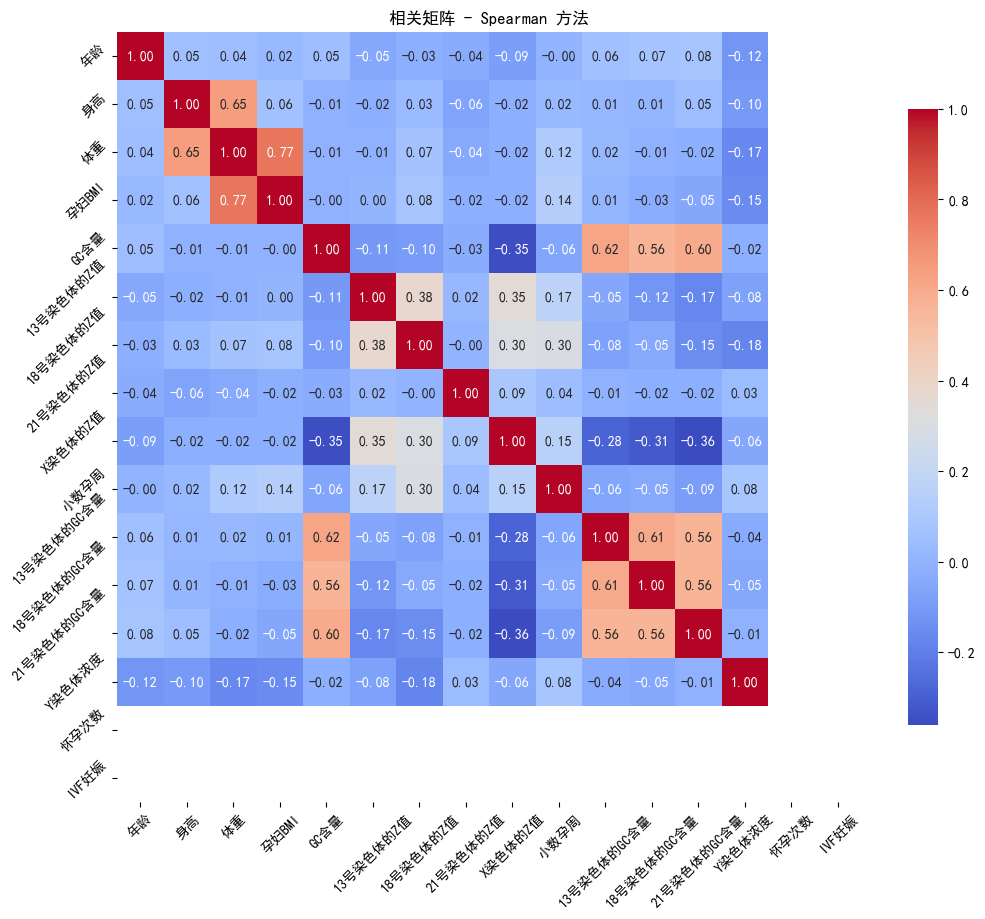

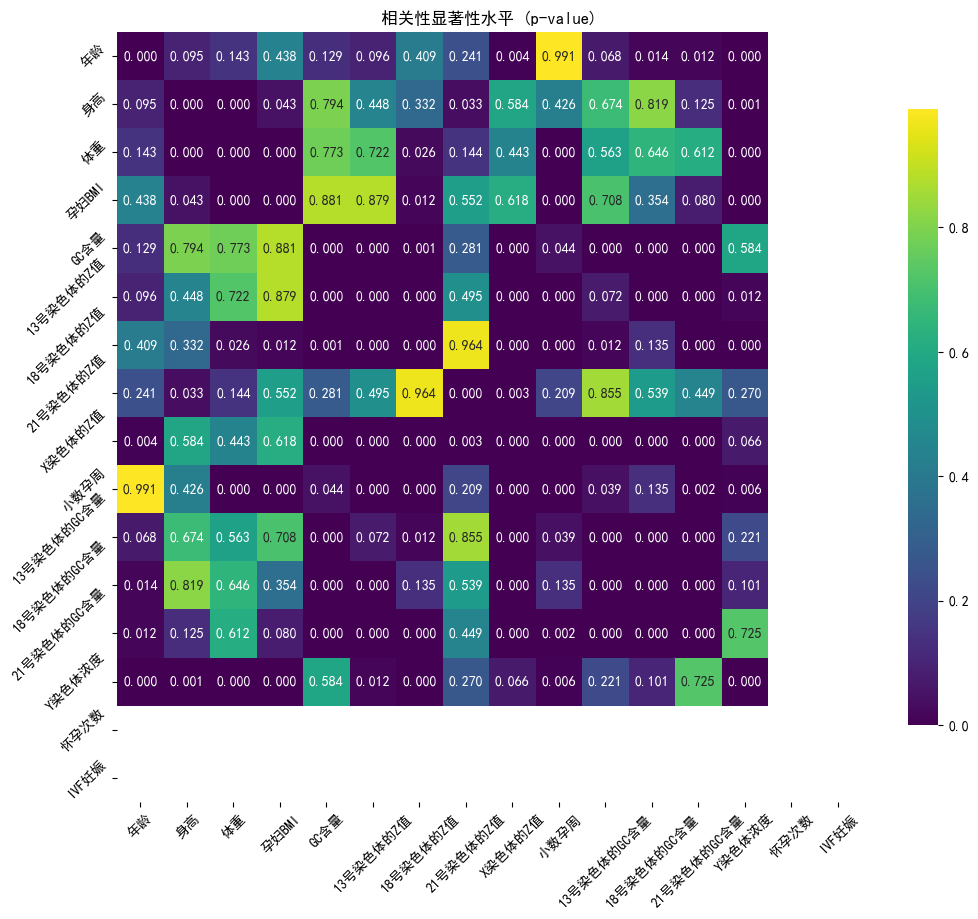

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# 假设 df_processed 和 needed_columns 已经定义
# 复制数据框以防止对原始数据造成修改
correlation_data = df_processed[needed_columns].copy()

# 尝试将所有列转换为数值类型，无法转换设置为 NaN
correlation_data = correlation_data.apply(pd.to_numeric, errors='coerce')

# 找出包含非数值的列
non_numeric_columns = [col for col in needed_columns if col not in correlation_data.columns or correlation_data[col].isna().all()]
print(f"将跳过以下非数值列或全 NaN 列: {non_numeric_columns}")

# 剔除非数值列
valid_columns = [col for col in needed_columns if col not in non_numeric_columns]

# 初始化相关矩阵和显著性矩阵
correlation_matrix = np.zeros((len(valid_columns), len(valid_columns)))
p_value_matrix = np.zeros((len(valid_columns), len(valid_columns)))

# 计算Spearman相关系数和p值
for i in range(len(valid_columns)):
    for j in range(len(valid_columns)):
        corr, p_value = spearmanr(correlation_data[valid_columns[i]], correlation_data[valid_columns[j]])
        correlation_matrix[i, j] = corr
        p_value_matrix[i, j] = p_value

# 把结果转换成DataFrame
correlation_df = pd.DataFrame(correlation_matrix, index=valid_columns, columns=valid_columns)
p_value_df = pd.DataFrame(p_value_matrix, index=valid_columns, columns=valid_columns)

# 可视化相关矩阵
plt.figure(figsize=(12, 10))
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})
plt.title('相关矩阵 - Spearman 方法')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# 可视化显著性水平
plt.figure(figsize=(12, 10))
sns.heatmap(p_value_df, annot=True, fmt=".3f", cmap='viridis', cbar_kws={"shrink": .8})
plt.title('相关性显著性水平 (p-value)')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [40]:
# 假设年龄列叫 '孕妇年龄'，BMI列叫 '孕妇BMI'
age_col = '小数孕周'
bmi_col = '孕妇BMI'

# 年龄分组
age_bins = [-np.inf, 12, 17, 21, 25, np.inf]
age_labels = [1, 2, 3, 4, 5]
df_processed['孕期组'] = pd.cut(df_processed[age_col], bins=age_bins, labels=age_labels, right=False)

# BMI分组
bmi_bins = [0, 18.5, 25, 30, np.inf]
bmi_labels = [1, 2, 3, 4]
df_processed['孕妇BMI组'] = pd.cut(df_processed[bmi_col], bins=bmi_bins, labels=bmi_labels, right=False)

# 生成16组合
df_processed['group16'] = df_processed['孕期组'].astype(str) + '_' + df_processed['孕妇BMI组'].astype(str)

# 查看结果
print(df_processed.head())


   序号  孕妇代码  年龄     身高    体重                 末次月经 IVF妊娠      检测日期  检测抽血次数  \
0   1  A001  31  160.0  72.0  2023-02-01 00:00:00     0  20230429       1   
1   2  A001  31  160.0  73.0  2023-02-01 00:00:00     0  20230531       2   
2   3  A001  31  160.0  73.0  2023-02-01 00:00:00     0  20230625       3   
3   4  A001  31  160.0  74.0  2023-02-01 00:00:00     0  20230716       4   
4   5  A002  32  149.0  74.0  2023-11-09 00:00:00     0  20240219       1   

    检测孕周  ...  21号染色体的GC含量  被过滤掉读段数的比例  染色体的非整倍体  怀孕次数  生产次数  胎儿是否健康  \
0  11w+6  ...     0.399399    0.027484       NaN     1     0       是   
1  15w+6  ...     0.391706    0.019617       NaN     1     0       是   
2  20w+1  ...     0.399480    0.022312       NaN     1     0       是   
3  22w+6  ...     0.397212    0.023280       NaN     1     0       是   
4  13w+6  ...     0.404868    0.024212       NaN     2     1       否   

        小数孕周  孕期组  孕妇BMI组  group16  
0  11.857143    1       3      1_3  
1  15.857143    2       3     

In [41]:
filter_columns = ['身高','体重','年龄','孕妇BMI', '13号染色体的Z值', '18号染色体的Z值', 'X染色体的Z值', '小数孕周', '18号染色体的GC含量', 'Y染色体浓度']

GAM summary:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    104.7506
Link Function:                     IdentityLink Log Likelihood:                               -590107.5973
Number of Samples:                         1082 AIC:                                           1180426.696
                                                AICc:                                         1180449.8469
                                                GCV:                                                 0.001
                                                Scale:                                              0.0008
                                                Pseudo R-Squared:                                   0.3412
Feature Function        

C:\Users\xia\AppData\Local\Temp\ipykernel_40340\3078626571.py:22: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


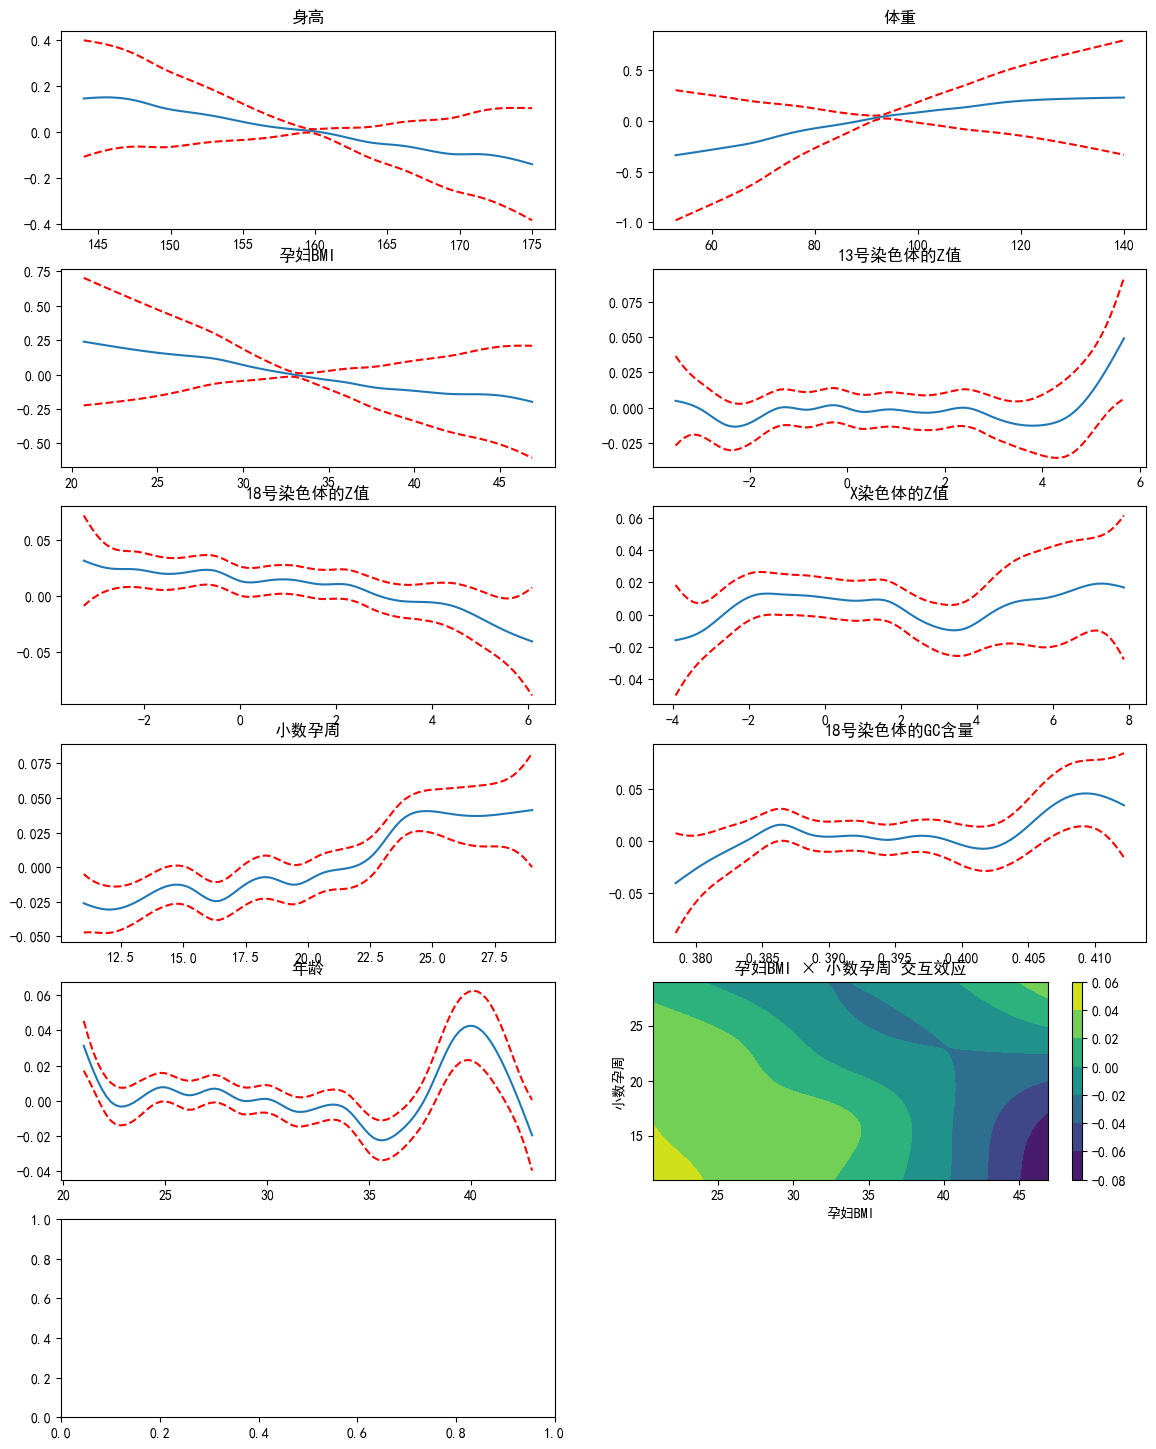

In [42]:
from pygam import LinearGAM, s, te
import matplotlib.pyplot as plt
import numpy as np
from pygam.terms import SplineTerm, TensorTerm


# 自变量、因变量
y = df_processed['Y染色体浓度']
X = df_processed[['身高','体重','孕妇BMI', 
                  '13号染色体的Z值', '18号染色体的Z值', 
                  'X染色体的Z值', '小数孕周', '18号染色体的GC含量', '年龄']]

# 构建 GAM 模型
gam = LinearGAM(
    s(0) + s(1) + s(2) +
    s(3) + s(4) + s(5) +
    s(6) + s(7) + s(8) +
    te(2,6)  # 交互项：BMI × 孕周
).fit(X, y)

print("GAM summary:")
print(gam.summary())

# 可视化
n_terms = len(gam.terms)   # term 总数（兼容旧版本）
fig, axs = plt.subplots((n_terms+1)//2, 2, figsize=(14, 18))
axs = axs.ravel()

for i, ax in enumerate(axs):
    if i >= n_terms:   # 多余子图留空
        ax.axis('off')
        continue

    term = gam.terms[i]

    if isinstance(term, TensorTerm):  
        # term.feature 返回涉及的两个变量索引
        f1, f2 = term.feature

        # 取这两个变量的数据范围
        x1 = np.linspace(X.iloc[:, f1].min(), X.iloc[:, f1].max(), 50)
        x2 = np.linspace(X.iloc[:, f2].min(), X.iloc[:, f2].max(), 50)
        XX = np.meshgrid(x1, x2)   # tuple of grids

        # 计算偏依赖
        Z = gam.partial_dependence(term=i, X=XX, meshgrid=True)

        # 绘制
        cs = ax.contourf(XX[0], XX[1], Z, cmap='viridis')
        fig.colorbar(cs, ax=ax)
        ax.set_title(f"{X.columns[f1]} × {X.columns[f2]} 交互效应")
        ax.set_xlabel(X.columns[f1])
        ax.set_ylabel(X.columns[f2])


    elif isinstance(term, SplineTerm):  
        # 单变量：画折线 + 置信区间
        XX = gam.generate_X_grid(term=i)
        pdp, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

        f = term.feature  # 对应的变量索引
        ax.plot(XX[:, f], pdp)
        ax.plot(XX[:, f], confi[:, 0], c='r', ls='--')
        ax.plot(XX[:, f], confi[:, 1], c='r', ls='--')
        ax.set_title(f'{X.columns[f]}')



GAM summary:
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     93.4523
Link Function:                     IdentityLink Log Likelihood:                               -586564.4986
Number of Samples:                         1082 AIC:                                          1173317.9019
                                                AICc:                                         1173336.1791
                                                GCV:                                                 0.001
                                                Scale:                                              0.0008
                                                Pseudo R-Squared:                                   0.3218
Feature Function        

C:\Users\xia\AppData\Local\Temp\ipykernel_40340\695467409.py:25: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


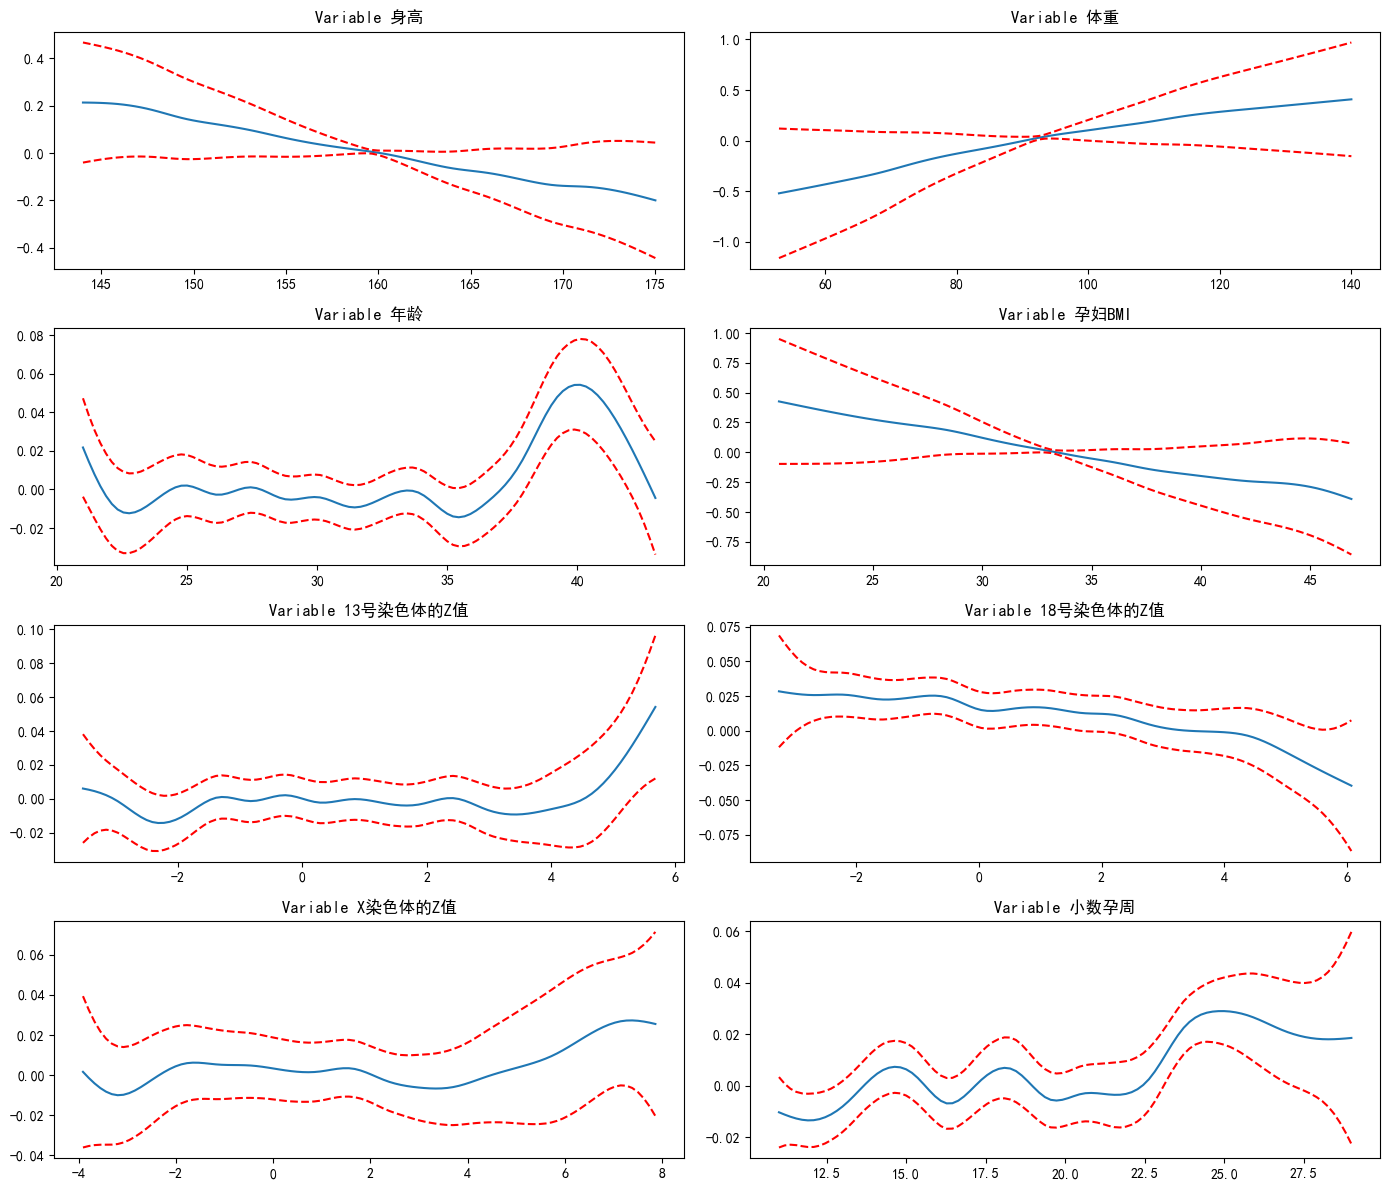

In [43]:
from pygam import LinearGAM, s, f, te
import matplotlib.pyplot as plt

# 自变量、因变量
y = df_processed['Y染色体浓度']
X = df_processed[['身高','体重','年龄','孕妇BMI', 
                  '13号染色体的Z值', '18号染色体的Z值', 
                  'X染色体的Z值', '小数孕周', '18号染色体的GC含量']]

# 构建 GAM 模型（对连续变量用平滑函数 s()）
gam = LinearGAM(
    s(0) +  # 身高
    s(1) +  # 体重
    s(2) +  # BMI
    s(3) +  # 13号染色体Z值
    s(4) +  # 18号染色体Z值
    s(5) +  # X染色体Z值
    s(6) +  # 小数孕周
    s(7) +  # 18号染色体GC含量
    te(2,6)
).fit(X, y)

# 打印模型的GCV/拟合度
print("GAM summary:")
print(gam.summary())

# 可视化每个变量的平滑效应
fig, axs = plt.subplots(4, 2, figsize=(14, 12))
axs = axs.ravel()
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    ax.set_title(f'Variable {X.columns[i]}')
plt.tight_layout()
plt.show()


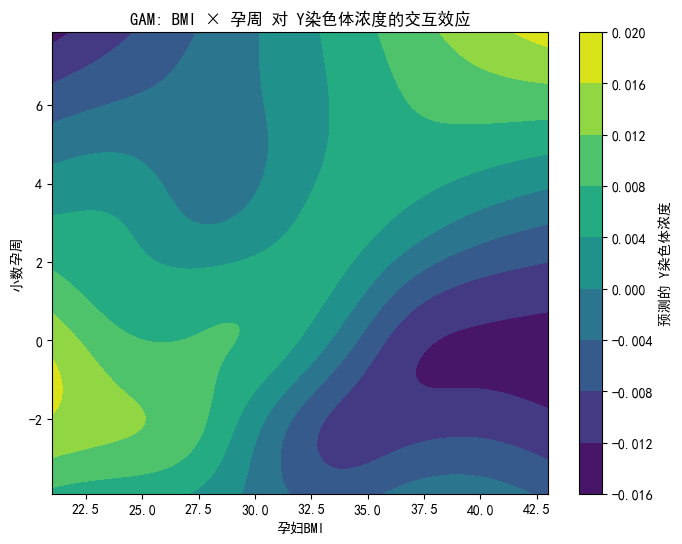

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# term=8 对应 te(2,6)
XX = gam.generate_X_grid(term=8, meshgrid=False)  
Z = gam.partial_dependence(term=8, X=XX)

# 取出 BMI 和孕周的唯一值
bmi_vals = np.unique(XX[:, 2])
week_vals = np.unique(XX[:, 6])

# 把 Z reshape 成 (len(bmi_vals), len(week_vals)) 矩阵
Z = Z.reshape(len(bmi_vals), len(week_vals))

# 画热力图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
cs = plt.contourf(bmi_vals, week_vals, Z.T, cmap='viridis')
cbar = plt.colorbar(cs)
cbar.set_label("预测的 Y染色体浓度")

plt.xlabel("孕妇BMI")
plt.ylabel("小数孕周")
plt.title("GAM: BMI × 孕周 对 Y染色体浓度的交互效应")
plt.show()

In [45]:
df_processed = df_processed.dropna(subset=['group16'])
grouped = df_processed.groupby('group16')
grouped_lists = {}
for name, group in grouped:
    grouped_lists[name] = group[filter_columns].values.tolist()
# 打印每个分组
for group_name, items in grouped_lists.items():
    print(f"Group {group_name}:")
    for item in items:
        print(item)

Group 1_3:
[160.0, 72.0, 31.0, 28.125, 0.782096634, -2.321211659, -0.062103083, 11.857142857142858, 0.389803052, 0.02593584]
[158.0, 71.5, 26.0, 28.64124339, 1.506720483, -0.994698056, -0.353765031, 11.0, 0.395150453, 0.049497736]
[159.0, 72.5, 26.0, 28.67766307, 1.324436807, 0.581488663, -0.861082986, 11.0, 0.400643766, 0.046937337]
[165.0, 80.0, 27.0, 29.38475666, 1.439859847, 1.845523433, 3.423393821, 11.0, 0.385783225, 0.049032977]
[163.0, 77.5, 32.0, 29.16933268, -0.061528304, -1.631720581, 0.589679056, 11.0, 0.392055214, 0.133580848]
[169.0, 85.0, 32.0, 29.76086271, 0.583941104, 1.353825157, 0.093198399, 11.714285714285714, 0.394659996, 0.054166998]
[170.0, 84.0, 25.0, 29.06574394, 0.33583004, 1.480438857, 0.261744701, 11.857142857142858, 0.391351104, 0.038769755]
[158.0, 74.0, 29.0, 29.64268547, -0.149569292, -1.028700975, 0.896578012, 11.857142857142858, 0.391802311, 0.081496899]
[168.0, 83.1, 28.0, 29.4422328204865, -0.835230624, -1.606990473, -0.771250598, 11.714285714285714,